In [1]:
%pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [2]:
import pandas as pd
import cfe.regression as rgsn
import seaborn as sns
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt


In [3]:
US_Data = 'https://docs.google.com/spreadsheets/d/1q5aGdIXILMcY5AzwxwD9lnQa6dRnrOuAjvTJABGxHZs/edit?usp=sharing'

In [4]:
p = read_sheets(US_Data,sheet='prices_adapted')

# Change column names to actual unit values
p["u"] = "Kg"

p["m"] = "USA"

# Adjust price to per Kg from per 100g
p["price"] = p["price"] * 10

# Filter for only 2017/2018 prices
p = p[p["t"] == "2017/2018"]

# Change price data from 2017/2018 to 2021 using avg US CPIs in 2017/2018 and 2021
cpi_2021 = 271.0
cpi_2018 = 250.0
p["price"] = p["price"] * (cpi_2021/cpi_2018)

p["t"] = "2021"

p_2021 = p

# codes = pd.read_csv("recipes.csv")

# codes = codes[["parent_foodcode", "parent_desc"]]
# c = codes.groupby("parent_foodcode").first()
# c.rename(columns = {"parent_foodcode": "j"})
# p = p.join(c, on="j")
# p_with_j = p # use later on for nutrition data
# p = p.drop("j", axis=1)
# p = p.rename(columns = {"parent_desc":"j"})

# # Now prices
# p = p.set_index(['t','m','j','u'])

# # Compute medians of prices for particular time, place and unit
# p = p.groupby(['t','m','j','u']).median()

# # Just keep metric units
# p = p.xs('Kg',level="u").squeeze().unstack('j')
# # Identify the common keys between x_filtered.index.levels[-1] and p.columns
# common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# # Now subset p with these keys and transpose the result.
# p = p[common_keys].T

In [5]:
p_2021

,t,j,m,price,u
10577,2021,11100000.0,USA,1.394236,Kg
10578,2021,11111000.0,USA,1.363655,Kg
10579,2021,11112110.0,USA,1.277698,Kg
10580,2021,11112210.0,USA,1.261450,Kg
10581,2021,11113000.0,USA,1.282637,Kg
...,...,...,...,...,...
15007,2021,95320200.0,USA,1.678316,Kg
15008,2021,95320500.0,USA,1.275714,Kg
15009,2021,95322200.0,USA,1.582938,Kg
15010,2021,95322500.0,USA,1.234921,Kg


In [6]:
x = read_sheets(US_Data,sheet='Food Expenditures 2021(qty)')
exp = x.copy()
x = x.merge(p_2021, on = 'j', how = 'left', suffixes = ('', "_y"))
x['expenditures'] = x['grams']/1000 * x['price']
x['j'] = x['food_name']
# x = c.drop(columns = ['t_x', 'grams', 'm_y', 'u', 'price'])
# x = x.rename(columns = {'m_x': 'm', 't_y': 't'})
x = x.set_index(['i','t','m','j'])["expenditures"].squeeze()
x = x.dropna()
# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

In [7]:
x

i       t     m    j                                                           
130378  2021  USA  Caesar dressing                                                 0.044625
                   Cheese, parmesan, dry grated                                    0.055222
                   Chicken, ns as to part and cooking method, ns as to skin eat    2.299008
                   Chicken, ns as to part and cooking method, skin not eaten       2.299008
                   Coffee, brewed                                                  0.424731
                                                                                     ...   
142310  2021  USA  Potato, mashed, ready-to-heat                                   0.225690
                   Sugar substitute, sucralose, powder                             0.036141
                   Vodka                                                           1.521590
                   Water, bottled, plain                                           0.244001


In [70]:
# Step 1: Filter goods by frequency (top 350)
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index

# Filter x and y to only include these popular goods.
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 2: Instead of random sampling, use all households present in y_filtered.
# Get all unique household ids from y_filtered.
common_ids = y_filtered.index.get_level_values('i').unique()

# Filter y and d to keep only households in common_ids.
# (This is effectively taking the full data that has corresponding expenditures.)
y_final = y_filtered[y_filtered.index.get_level_values('i').isin(common_ids)]
d_final = d[d.index.get_level_values('i').isin(common_ids)]

# Filter y and d to match
# sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)
# y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
# d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_final:", y_final.shape)
print("Shape of d_final:", d_final.shape)


Shape of y_final: (84073,)
Shape of d_final: (6710, 3)


In [71]:
# from cfe import Regression

# # Run the regression
# rfinal = Regression(y=y_final, d=d_final, compute_se=False, rectify=False, 
#                     min_obs=10, min_prop_items=0.002)
# rfinal.to_pickle('USrgsnfinal')

In [34]:
rfinal = rgsn.read_pickle('USrgsnfinal')

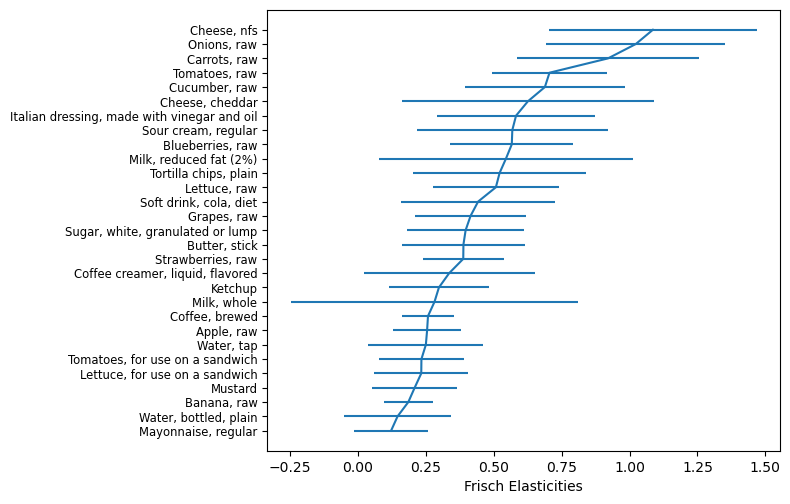

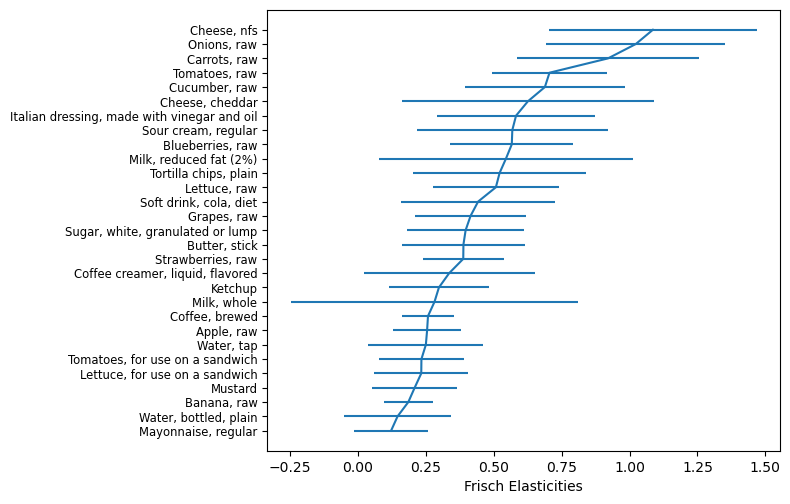

In [35]:
rfinal.graph_beta()

In [36]:
rfinal.beta.index

Index(['Apple, raw', 'Banana, raw', 'Blueberries, raw', 'Butter, stick',
       'Carrots, raw', 'Cheese, cheddar', 'Cheese, nfs',
       'Coffee creamer, liquid, flavored', 'Coffee, brewed', 'Cucumber, raw',
       'Grapes, raw', 'Italian dressing, made with vinegar and oil', 'Ketchup',
       'Lettuce, for use on a sandwich', 'Lettuce, raw', 'Mayonnaise, regular',
       'Milk, reduced fat (2%)', 'Milk, whole', 'Mustard', 'Onions, raw',
       'Soft drink, cola, diet', 'Sour cream, regular', 'Strawberries, raw',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Tortilla chips, plain', 'Water, bottled, plain',
       'Water, tap'],
      dtype='object', name='j')

In [75]:
import numpy as np

xhat = rfinal.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median


In [20]:
p_2021

,t,j,m,price,u
10577,2021,11100000.0,USA,1.394236,Kg
10578,2021,11111000.0,USA,1.363655,Kg
10579,2021,11112110.0,USA,1.277698,Kg
10580,2021,11112210.0,USA,1.261450,Kg
10581,2021,11113000.0,USA,1.282637,Kg
...,...,...,...,...,...
15007,2021,95320200.0,USA,1.678316,Kg
15008,2021,95320500.0,USA,1.275714,Kg
15009,2021,95322200.0,USA,1.582938,Kg
15010,2021,95322500.0,USA,1.234921,Kg


In [22]:
pint = p_2021.merge(exp[['j', 'food_name']], on = 'j', how = 'left')
pint = pint.drop(columns = ['j'])
pint = pint.rename(columns = {'food_name': 'j'})

In [25]:
pint = pint.groupby(['t','m','j','u']).median()
pint

price
t    m   j                                            u            
2021 USA Agave liquid sweetener                       Kg  11.828497
         Alcoholic malt beverage, sweetened           Kg   5.226247
         Alfalfa sprouts, raw                         Kg  22.495126
         Alfredo sauce                                Kg   6.987828
         Almond butter                                Kg  24.507558
...                                                             ...
         Yogurt, ns as to type of milk, plain         Kg   5.719330
         Yogurt, soy                                  Kg  12.756803
         Yogurt, whole milk, flavors other than fruit Kg   7.336165
         Yogurt, whole milk, fruit                    Kg   6.039056
         Yogurt, whole milk, plain                    Kg   5.719330

[3169 rows x 1 columns]

In [39]:
rfinal.beta.index

Index(['Apple, raw', 'Banana, raw', 'Blueberries, raw', 'Butter, stick',
       'Carrots, raw', 'Cheese, cheddar', 'Cheese, nfs',
       'Coffee creamer, liquid, flavored', 'Coffee, brewed', 'Cucumber, raw',
       'Grapes, raw', 'Italian dressing, made with vinegar and oil', 'Ketchup',
       'Lettuce, for use on a sandwich', 'Lettuce, raw', 'Mayonnaise, regular',
       'Milk, reduced fat (2%)', 'Milk, whole', 'Mustard', 'Onions, raw',
       'Soft drink, cola, diet', 'Sour cream, regular', 'Strawberries, raw',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Tortilla chips, plain', 'Water, bottled, plain',
       'Water, tap'],
      dtype='object', name='j')

In [40]:
p_us = (
    p_2021
      .query("t==2021 & m=='USA' & u=='Kg'")
      .groupby('j')['price']
      .mean()               # now a pd.Series indexed by j
)

# 2) align to exactly the set of goods you estimated, fill missing with 1
pbar = (
    p_us
      .reindex(rfinal.beta.index)  # keep only the goods in your regression
      .fillna(1.0)                 # if a good wasn’t in p_us, give it price = 1
)

In [41]:
pbar

j
Apple, raw                                     1.0
Banana, raw                                    1.0
Blueberries, raw                               1.0
Butter, stick                                  1.0
Carrots, raw                                   1.0
Cheese, cheddar                                1.0
Cheese, nfs                                    1.0
Coffee creamer, liquid, flavored               1.0
Coffee, brewed                                 1.0
Cucumber, raw                                  1.0
Grapes, raw                                    1.0
Italian dressing, made with vinegar and oil    1.0
Ketchup                                        1.0
Lettuce, for use on a sandwich                 1.0
Lettuce, raw                                   1.0
Mayonnaise, regular                            1.0
Milk, reduced fat (2%)                         1.0
Milk, whole                                    1.0
Mustard                                        1.0
Onions, raw                  

In [38]:
.mean(axis=1).fillna(1) # Only use prices for goods we can estimatepbar = pint.loc[rfinal.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

KeyError: "Index(['Apple, raw', 'Banana, raw', 'Blueberries, raw', 'Butter, stick',\n       'Carrots, raw', 'Cheese, cheddar', 'Cheese, nfs',\n       'Coffee creamer, liquid, flavored', 'Coffee, brewed', 'Cucumber, raw',\n       'Grapes, raw', 'Italian dressing, made with vinegar and oil', 'Ketchup',\n       'Lettuce, for use on a sandwich', 'Lettuce, raw', 'Mayonnaise, regular',\n       'Milk, reduced fat (2%)', 'Milk, whole', 'Mustard', 'Onions, raw',\n       'Soft drink, cola, diet', 'Sour cream, regular', 'Strawberries, raw',\n       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',\n       'Tomatoes, raw', 'Tortilla chips, plain', 'Water, bottled, plain',\n       'Water, tap'],\n      dtype='object', name='j') not in index"

,t,j,m,price,u


In [16]:
df = (
    p_2021
      # bring in the human‐readable name for each code j
      .merge(
         exp.reset_index()[['j','food_name']],
         on='j', how='left'
       )
      # restrict to the exact slice we care about
      .query("t == 2021 & m == 'USA' & u == 'Kg'")
)
print(df)
# 2) Now group by food_name and take the mean of price
p_us = df.groupby('food_name')['price'].mean()

# 3) (optional) if you want to reindex this back to exactly the goods in your regression:
pbar = (
    p_us
      .reindex(rfinal.beta.index)   # only keep those you estimated
      .fillna(1.0)                  # dummy price=1 if missing
)

# done:
print(p_us.head())
print(pbar.head())

Empty DataFrame
Columns: [t, j, m, price, u, food_name]
Index: []


AttributeError: 'NoneType' object has no attribute 'index'

In [12]:
pint = p_2021.merge(exp[['j', 'food_name']], on = 'j', how = 'left')
pint = pint.groupby('food_name')

,t_x,j,m_x,price,u,i,t_y,m_y,grams,food_name
0,2021,11100000.0,USA,1.394236,Kg,130454.0,2021.0,USA,122.00,"Milk, nfs"
1,2021,11100000.0,USA,1.394236,Kg,130611.0,2021.0,USA,30.50,"Milk, nfs"
2,2021,11100000.0,USA,1.394236,Kg,131213.0,2021.0,USA,244.00,"Milk, nfs"
3,2021,11100000.0,USA,1.394236,Kg,131781.0,2021.0,USA,122.00,"Milk, nfs"
4,2021,11100000.0,USA,1.394236,Kg,131784.0,2021.0,USA,183.00,"Milk, nfs"
5,2021,11100000.0,USA,1.394236,Kg,131821.0,2021.0,USA,122.00,"Milk, nfs"
6,2021,11100000.0,USA,1.394236,Kg,131895.0,2021.0,USA,162.67,"Milk, nfs"
7,2021,11100000.0,USA,1.394236,Kg,131997.0,2021.0,USA,142.34,"Milk, nfs"
8,2021,11100000.0,USA,1.394236,Kg,132433.0,2021.0,USA,122.00,"Milk, nfs"
9,2021,11100000.0,USA,1.394236,Kg,132582.0,2021.0,USA,183.00,"Milk, nfs"


## multiply nutrients by 10 for kgs!

In [ ]:
# 1) filter to 2021 × USA × Kg
p_us = (
    p_2021
      .query("t == 2021 & m == 'USA' & u == 'Kg'")
      .groupby('j')['price']
      .mean()            # if there happen to be duplicates, take the mean
)

# 2) now re‐index to exactly the goods in your regression,
#    giving any missing ones a dummy price of 1
pbar = (
    p_us
      .reindex(rfinal.beta.index)  # keep only the goods you estimated
      .fillna(1)                   # if a good wasn’t in p_us, give it price = 1
)

In [9]:
p_2021

,t,j,m,price,u
10577,2021,11100000.0,USA,1.394236,Kg
10578,2021,11111000.0,USA,1.363655,Kg
10579,2021,11112110.0,USA,1.277698,Kg
10580,2021,11112210.0,USA,1.261450,Kg
10581,2021,11113000.0,USA,1.282637,Kg
...,...,...,...,...,...
15007,2021,95320200.0,USA,1.678316,Kg
15008,2021,95320500.0,USA,1.275714,Kg
15009,2021,95322200.0,USA,1.582938,Kg
15010,2021,95322500.0,USA,1.234921,Kg


In [26]:
pbar

j
Apple, raw                                     1.0
Banana, raw                                    1.0
Blueberries, raw                               1.0
Butter, stick                                  1.0
Carrots, raw                                   1.0
Cheese, cheddar                                1.0
Cheese, nfs                                    1.0
Coffee creamer, liquid, flavored               1.0
Coffee, brewed                                 1.0
Cucumber, raw                                  1.0
Grapes, raw                                    1.0
Italian dressing, made with vinegar and oil    1.0
Ketchup                                        1.0
Lettuce, for use on a sandwich                 1.0
Lettuce, raw                                   1.0
Mayonnaise, regular                            1.0
Milk, reduced fat (2%)                         1.0
Milk, whole                                    1.0
Mustard                                        1.0
Onions, raw                  

In [14]:
pbar = p_2021.mean(axis=1)

# Instead of directly indexing with result.beta.index (which fails for missing keys),
# reindex pbar to have the same index as result.beta and fill missing prices with 1.
pbar = pbar.reindex(result.beta.index, fill_value=1)

# (Optional) Get the common keys, which should be all keys in result.beta.index:
common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]

# Replace any remaining missing values with 1.
pbar = pbar.replace(np.nan, 1)

# Finally, define a function to change the price of a single good in the price vector.
def my_prices(p0, j, p=pbar):
    """
    Change price of the jth good to p0, holding all other prices fixed.
    
    Parameters:
      p0 : float
          New price for the jth good.
      j : label
          Identifier for the good (must be present in p).
      p : pd.Series
          Price vector (default is pbar).
    
    Returns:
      pd.Series : A new price vector with the updated value.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys


TypeError: can only concatenate str (not "float") to str